# Setup

In [1]:
import os
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FixedLocator
from matplotlib import colors

import json
from scipy.stats import gaussian_kde

from typing import Any, Dict, Tuple, List, Optional

import tensorflow as tf
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score
)

import datetime

plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 12,
    "font.family": "sans-serif",
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    #"axes.spines.top": False,
    #"axes.spines.right": False,
    "legend.frameon": False
    #"axes.grid" : True,
    #"grid.color": "gray",
    #"grid.linestyle": "--",
    #"grid.linewidth": 0.5,
    #"grid.alpha": 0.3,
})

In [2]:
TELESCOPE = {
    "LUVOIR": dict(prefix="B",
                   region_bins={"UV": 8,  "Vis": 94,  "NIR": 49}),
    "HABEX" : dict(prefix="SS",
                   region_bins={"UV": 7,  "Vis":109,  "NIR": 25}),
}

def parse_example(example_proto: tf.Tensor,
                  input_stats: Dict[str, Tuple[float, float]],
                  output_stats: Dict[str, Any],
                  telescope: str = "LUVOIR"):

    meta   = TELESCOPE[telescope]
    pfx    = meta["prefix"]
    bins   = meta["region_bins"]

    # 1) Define raw feature schemas.
    raw_input_features = {f'NOISY_ALBEDO_{pfx}-{r}': tf.io.VarLenFeature(tf.float32)
              for r in ['NIR','UV','Vis']}

    raw_output_features = {
        # Planetary parameters.
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY":           tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE":   tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE":      tf.io.FixedLenFeature([], tf.float32),

        # Chemical abundances.
        'CH4':  tf.io.FixedLenFeature([], tf.float32),
        #'CO':   tf.io.FixedLenFeature([], tf.float32),
        'CO2':  tf.io.FixedLenFeature([], tf.float32),
        'H2O':  tf.io.FixedLenFeature([], tf.float32),
        'N2':   tf.io.FixedLenFeature([], tf.float32),
        #'N2O':  tf.io.FixedLenFeature([], tf.float32),
        'O2':   tf.io.FixedLenFeature([], tf.float32),
        'O3':   tf.io.FixedLenFeature([], tf.float32),

        'Earth_type': tf.io.FixedLenFeature([], tf.string)
    }

    # 2) Parse the example.
    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # 3) Normalize input spectra.
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_{pfx}-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)

        mean = input_stats[region][0]
        std  = input_stats[region][1]
        normalized = (spectrum - mean) / std

        normalized   = tf.reshape(normalized, [bins[region], 1])
        normalized_inputs[f'NOISY_ALBEDO_{pfx}-{region}'] = normalized

    # 4) Process outputs.
    physical_outputs = []
    main_chemical_outputs = []
    other_chemical_outputs = []

    # 4a) Process planetary parameters (physical outputs).
    for param in ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]:
        val = parsed[param]
        # To avoid a very ponctual error we found
        # the floating point precision error generates a single NaN value here :(
        if val == 273.15:
            val += 0.00002
        min_  = output_stats['physical_output_stats'][param][0]
        max_  = output_stats['physical_output_stats'][param][1]
        best_n  = output_stats['physical_output_stats'][param][2]
        processed = (val - min_) / (max_ - min_)
        processed = tf.math.pow(float(processed), float(1/best_n))
        physical_outputs.append(processed)

    # 4b) Process main chemical abundances.
    for chem in ['O2', 'O3']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1/best_n))
        main_chemical_outputs.append(processed)

    # 4c) Process other chemical abundances.
    for chem in ['CH4', 'CO2', 'H2O', 'N2']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1 / best_n))
        other_chemical_outputs.append(processed)

    grouped_outputs = {
        'physical_output': physical_outputs,              # shape (4,)
        'main_chemical_output': main_chemical_outputs,    # shape (2,)
        'other_chemical_output': other_chemical_outputs,  # shape (7,)
        'earth_type': parsed['Earth_type']               # shape (1,)
    }

    return normalized_inputs, grouped_outputs


def read_tfrecord(file_path: str,
                  telescope: str = "LUVOIR",
                  batch_size: int = 1024,
                  shuffle_buffer: Optional[int] = None,
                  repeat: bool = False):

    meta  = TELESCOPE[telescope]
    pfx   = meta["prefix"]

    with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
        stats = json.load(f)

    # Create lookup dictionaries for input normalization statistics.
    input_stats = {r: (stats['inputs'][f'{pfx}-{r}']['mean'],
                       stats['inputs'][f'{pfx}-{r}']['std'])
                   for r in ['UV','Vis','NIR']}

    physical_keys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    physical_output_stats = {
        key: (stats['outputs'][key]['min'], stats['outputs'][key]['max'], stats['outputs'][key]['best_n'])
        for key in physical_keys
    }

    chemical_keys = ['CH4', 'CO2', 'H2O', 'N2', 'O2', 'O3']
    chemical_output_stats = {
        key: stats['outputs'][key] for key in chemical_keys
    }

    output_stats: Dict[str, Any] = {
        'physical_output_stats': physical_output_stats,
        'chemical_output_stats': chemical_output_stats
    }

    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset using the parse_example function.
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats, telescope=telescope),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    return parsed_dataset

# DENORMALIZING AND ORGANIZING DATA

In [3]:
with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
    stats = json.load(f)

def denorm_physical(processed, name):
    """processed is 1-D array in (0-1)**(1/n) space."""
    pmin, pmax, n = (stats['outputs'][name][k]
                     for k in ('min', 'max', 'best_n'))
    return (processed ** n) * (pmax - pmin) + pmin

def denorm_chem(processed, name):
    """processed is (val)**(1/n) space."""
    n = stats['outputs'][name]['best_n']
    return processed ** n

def safe_log10(series):
    arr  = series.to_numpy(dtype=float)
    out  = np.full(arr.shape, np.nan, dtype=float)
    pos_mask = arr > 0
    if pos_mask.any():
        out[pos_mask] = np.log10(arr[pos_mask])

    return pd.Series(out, index=series.index)

def _get_xy(df, true_col, pred_col):
    tmp = df[[true_col, pred_col]].dropna()
    return tmp[true_col].to_numpy(), tmp[pred_col].to_numpy()

In [4]:
PATH = "/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/test.tfrecord"

luvoir_ds = read_tfrecord(PATH, telescope='LUVOIR', batch_size=1024).cache().prefetch(tf.data.AUTOTUNE)
habex_ds  = read_tfrecord(PATH, telescope='HABEX',  batch_size=1024).cache().prefetch(tf.data.AUTOTUNE)

model_LUVOIR = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/LUVOIR_NEW.keras")
model_HABEX = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/HABEX_NEW.keras")

In [5]:
def get_predictions(ds, model):
    phys_cols       = ["RADIUS_REL_EARTH", "GRAVITY", "TEMP", "PRESSURE"]
    main_chem_cols  = ['O2', 'O3']
    other_chem_cols = ['CH4', 'CO2', 'H2O', 'N2']

    y_true_phys_all   = []
    y_true_main_all   = []
    y_true_other_all  = []
    y_pred_phys_all   = []
    y_pred_main_all   = []
    y_pred_other_all  = []
    earth_types_all   = []

    for x_batch, y_batch in ds:
        preds = model(x_batch, training=False)

        y_true_phys_all.append(y_batch['physical_output'].numpy())
        y_true_main_all.append(y_batch['main_chemical_output'].numpy())
        y_true_other_all.append(y_batch['other_chemical_output'].numpy())

        y_pred_phys_all.append(preds['physical_output'].numpy())
        y_pred_main_all.append(preds['main_chemical_output'].numpy())
        y_pred_other_all.append(preds['other_chemical_output'].numpy())

        earth_types_all.append(y_batch['earth_type'].numpy())

    y_true_phys_all  = np.concatenate(y_true_phys_all,  axis=0)
    y_true_main_all  = np.concatenate(y_true_main_all,  axis=0)
    y_true_other_all = np.concatenate(y_true_other_all, axis=0)
    y_pred_phys_all  = np.concatenate(y_pred_phys_all,  axis=0)
    y_pred_main_all  = np.concatenate(y_pred_main_all,  axis=0)
    y_pred_other_all = np.concatenate(y_pred_other_all, axis=0)
    earth_types_all  = np.concatenate(earth_types_all).astype('U')

    true_phys_cols   = [f'true_{c}' for c in phys_cols]
    pred_phys_cols   = [f'pred_{c}' for c in phys_cols]
    true_main_cols   = [f'true_{c}' for c in main_chem_cols]
    pred_main_cols   = [f'pred_{c}' for c in main_chem_cols]
    true_other_cols  = [f'true_{c}' for c in other_chem_cols]
    pred_other_cols  = [f'pred_{c}' for c in other_chem_cols]

    df = pd.concat(
        [
            pd.Series(earth_types_all, name='earth_type'),
            pd.DataFrame(y_true_phys_all,  columns=true_phys_cols),
            pd.DataFrame(y_pred_phys_all,  columns=pred_phys_cols),
            pd.DataFrame(y_true_main_all,  columns=true_main_cols),
            pd.DataFrame(y_pred_main_all,  columns=pred_main_cols),
            pd.DataFrame(y_true_other_all, columns=true_other_cols),
            pd.DataFrame(y_pred_other_all, columns=pred_other_cols)
        ],
        axis=1
    )

    physical_key_map = {
    "RADIUS_REL_EARTH": "OBJECT-RADIUS-REL-EARTH",
    "GRAVITY": "OBJECT-GRAVITY",
    "TEMP": "ATMOSPHERE-TEMPERATURE",
    "PRESSURE": "ATMOSPHERE-PRESSURE"
    }

    for short_name, json_key in physical_key_map.items():
        true_col = f'true_{short_name}'
        pred_col = f'pred_{short_name}'
        new_true_col = f'{true_col}_original'
        new_pred_col = f'{pred_col}_original'

        df[new_true_col] = denorm_physical(df[true_col], json_key)
        df[new_pred_col] = denorm_physical(df[pred_col], json_key)

    all_chem_cols = main_chem_cols + other_chem_cols

    for chem_name in all_chem_cols:
        true_col = f'true_{chem_name}'
        pred_col = f'pred_{chem_name}'
        new_true_col = f'{true_col}_original'
        new_pred_col = f'{pred_col}_original'

        df[new_true_col] = denorm_chem(df[true_col], chem_name)
        df[new_pred_col] = denorm_chem(df[pred_col], chem_name)

    sigma = {}

    all_features = phys_cols + main_chem_cols + other_chem_cols

    for feat in all_features:
        true_col = f'true_{feat}_original'
        pred_col = f'pred_{feat}_original'

        res = df[pred_col] - df[true_col]

        sigma[feat] = res.std(ddof=1)

        df[f'sigma_{feat}_original'] = (res / sigma[feat]).abs()

    sigma_log = {}

    for feat in all_chem_cols:
        true_lin = df[f'true_{feat}_original']
        pred_lin = df[f'pred_{feat}_original']

        df[f'true_{feat}_log'] = safe_log10(true_lin)
        df[f'pred_{feat}_log'] = safe_log10(pred_lin)

        res_log = df[f'pred_{feat}_log'] - df[f'true_{feat}_log']

        valid_res = res_log.dropna()
        sigma = valid_res.std(ddof=1)
        sigma_log[feat] = sigma if sigma > 0 else np.nan

        df[f'sigma_{feat}_log'] = (res_log / sigma_log[feat]).abs()

    return df

In [6]:
results_df_LUVOIR = get_predictions(luvoir_ds, model_LUVOIR)
results_df_HABEX = get_predictions(habex_ds, model_HABEX)

In [7]:
results_df_LUVOIR[['true_O2_log', 'pred_O2_log',
       'sigma_O2_log', 'true_O3_log', 'pred_O3_log', 'sigma_O3_log']].head()

,true_O2_log,pred_O2_log,sigma_O2_log,true_O3_log,pred_O3_log,sigma_O3_log
0,-0.043374,-0.078329,0.066113,-4.952451,-5.013336,0.061754
1,-0.207609,-0.234300,0.050483,-5.631205,-5.649549,0.018605
2,-0.707125,-0.712027,0.009272,-4.581435,-4.558737,0.023022
3,-0.874917,-0.689727,0.350268,-5.005785,-4.996120,0.009803
4,-1.482231,-1.171646,0.587441,-5.667622,-5.848601,0.183563


# SOME STATISTICS

In [8]:
def get_stats_O2O3(df):
  stats = {}

  for gas in ['O2', 'O3']:
      mask_zero = df[f'true_{gas}_original'] == 0
      preds     = df.loc[mask_zero, f'pred_{gas}_original']

      stats[gas] = {
          'mean' : preds.mean(),
          'std'  : preds.std(ddof=1),
          'median': preds.median(),
          'rmse' : np.sqrt(np.mean(preds**2)),
          'N'    : mask_zero.sum()
      }

  return pd.DataFrame(stats).T

In [9]:
get_stats_O2O3(results_df_LUVOIR)

,mean,std,median,rmse,N
O2,1.052967e-04,2.064667e-03,0.0,2.067477e-03,28559.0
O3,1.104847e-09,2.180728e-08,0.0,2.183940e-08,28559.0


In [10]:
get_stats_O2O3(results_df_HABEX)

,mean,std,median,rmse,N
O2,1.046277e-04,2.569428e-03,0.0,2.571110e-03,28559.0
O3,9.367360e-10,2.597499e-08,0.0,2.598878e-08,28559.0


In [11]:
def _rows_for_block(label_df, etype):
    _phys  = ["RADIUS_REL_EARTH", "GRAVITY", "TEMP", "PRESSURE"]
    _main  = ["O2", "O3"]
    _other = ["CH4", "CO2", "H2O", "N2"]
    _abund = _main + _other

    rows = []
    for feat in _phys:
        y_t, y_p = _get_xy(label_df, f'true_{feat}_original', f'pred_{feat}_original')
        rows.append(_metrics_dict(y_t, y_p, etype, feat, 'linear'))
    for feat in _abund:
        y_t, y_p = _get_xy(label_df, f'true_{feat}_log', f'pred_{feat}_log')
        rows.append(_metrics_dict(y_t, y_p, etype, feat, 'log10'))
    return rows

def _metrics_dict(y_true, y_pred, etype, feat, space):
    if y_true.size == 0:
        nan_dict = {k: np.nan for k in
                    ['R²','Explained Variance','MSE','RMSE','MAE','Median Abs Error']}
    else:
        mse  = mean_squared_error(y_true, y_pred)
        nan_dict = {
            'R²'                : r2_score(y_true, y_pred),
            'Explained Variance': explained_variance_score(y_true, y_pred),
            'MSE'               : mse,
            'RMSE'              : np.sqrt(mse),
            'MAE'               : mean_absolute_error(y_true, y_pred),
            'Median Abs Error'  : median_absolute_error(y_true, y_pred)
        }
    nan_dict.update({'earth_type': etype, 'feature': feat, 'space': space})
    return nan_dict

def get_stats(df, stratify=False):
    if stratify:
        rows = []
        for etype, df_etype in df.groupby('earth_type'):
            etype = etype.decode() if isinstance(etype, bytes) else etype
            rows.extend(_rows_for_block(df_etype, etype))
    else:
        rows = _rows_for_block(df, 'All')
    return (pd.DataFrame(rows)
              .set_index(['earth_type', 'feature', 'space'])
              .sort_index())

In [12]:
get_stats(results_df_LUVOIR)

R²  Explained Variance  \
earth_type feature          space                                  
All        CH4              log10   0.862723            0.862768   
           CO2              log10   0.689607            0.689655   
           GRAVITY          linear  0.842403            0.845649   
           H2O              log10   0.816410            0.818057   
           N2               log10   0.450184            0.473202   
           O2               log10   0.774523            0.775818   
           O3               log10   0.211574            0.215694   
           PRESSURE         linear  0.831683            0.833664   
           RADIUS_REL_EARTH linear  0.845669            0.849350   
           TEMP             linear  0.419662            0.429034   

                                             MSE        RMSE         MAE  \
earth_type feature          space                                          
All        CH4              log10       0.428594    0.654671    0.436775   
           CO2              log10       0.407810    0.638600    0.481749   
           GRAVITY          linear      0.967546    0.983639    0.731226   
           H2O              log10       0.188525    0.434195    0.291111   
           N2               log10       0.015435    0.124236    0.048933   
           O2               log10       0.281143    0.530229    0.346711   
           O3               log10       0.977142    0.988505    0.232301   
           PRESSURE         linear  40122.117188  200.305060  144.421036   
           RADIUS_REL_EARTH linear      0.004206    0.064855    0.048307   
           TEMP             linear    242.256836   15.564602   11.388399   

                                    Median Abs Error  
earth_type feature          space                     
All        CH4              log10           0.267516  
           CO2              log10           0.368168  
           GRAVITY          linear          0.550742  
           H2O              log10           0.184179  
           N2               log10           0.011073  
           O2               log10           0.211364  
           O3               log10           0.109379  
           PRESSURE         linear        102.305420  
           RADIUS_REL_EARTH linear          0.036408  
           TEMP             linear          8.289276

In [13]:
get_stats(results_df_HABEX)

R²  Explained Variance  \
earth_type feature          space                                  
All        CH4              log10   0.823092            0.823170   
           CO2              log10   0.706483            0.706503   
           GRAVITY          linear  0.803826            0.804121   
           H2O              log10   0.745835            0.746731   
           N2               log10   0.368169            0.386101   
           O2               log10   0.777700            0.778209   
           O3               log10   0.535873            0.539748   
           PRESSURE         linear  0.794346            0.794351   
           RADIUS_REL_EARTH linear  0.806620            0.807025   
           TEMP             linear  0.170678            0.211112   

                                             MSE        RMSE         MAE  \
earth_type feature          space                                          
All        CH4              log10       0.552328    0.743188    0.498060   
           CO2              log10       0.385628    0.620990    0.443590   
           GRAVITY          linear      1.204379    1.097442    0.811090   
           H2O              log10       0.260998    0.510879    0.358197   
           N2               log10       0.019076    0.138118    0.054958   
           O2               log10       0.282496    0.531504    0.363742   
           O3               log10       0.580091    0.761637    0.199522   
           PRESSURE         linear  49022.191406  221.409556  158.953995   
           RADIUS_REL_EARTH linear      0.005270    0.072597    0.053716   
           TEMP             linear    346.192810   18.606257   13.472356   

                                    Median Abs Error  
earth_type feature          space                     
All        CH4              log10           0.324545  
           CO2              log10           0.304835  
           GRAVITY          linear          0.606186  
           H2O              log10           0.239177  
           N2               log10           0.011336  
           O2               log10           0.236696  
           O3               log10           0.099659  
           PRESSURE         linear        112.055115  
           RADIUS_REL_EARTH linear          0.040102  
           TEMP             linear          9.646759

In [14]:
get_stats(results_df_LUVOIR, stratify=True)

R²  Explained Variance  \
earth_type  feature          space                                  
archean     CH4              log10   0.818165            0.819047   
            CO2              log10   0.593840            0.594279   
            GRAVITY          linear  0.846995            0.851016   
            H2O              log10   0.658649            0.682362   
            N2               log10   0.383241            0.421862   
            O2               log10        NaN                 NaN   
            O3               log10        NaN                 NaN   
            PRESSURE         linear  0.837106            0.839845   
            RADIUS_REL_EARTH linear  0.850513            0.854941   
            TEMP             linear  0.406456            0.409073   
modern      CH4              log10  -0.160021           -0.153876   
            CO2              log10   0.177928            0.182180   
            GRAVITY          linear  0.851958            0.852313   
            H2O              log10   0.729902            0.731136   
            N2               log10   0.339809            0.380382   
            O2               log10   0.543709            0.545855   
            O3               log10   0.879788            0.880632   
            PRESSURE         linear  0.841329            0.841339   
            RADIUS_REL_EARTH linear  0.855646            0.856097   
            TEMP             linear  0.411319            0.430909   
proterozoic CH4              log10   0.578718            0.588086   
            CO2              log10   0.470166            0.471290   
            GRAVITY          linear  0.822404            0.833810   
            H2O              log10   0.818158            0.821806   
            N2               log10   0.441495            0.470566   
            O2               log10   0.378412            0.383132   
            O3               log10  -2.591229           -2.558484   
            PRESSURE         linear  0.810534            0.820053   
            RADIUS_REL_EARTH linear  0.824738            0.837536   
            TEMP             linear  0.448464            0.455975   

                                              MSE        RMSE         MAE  \
earth_type  feature          space                                          
archean     CH4              log10       0.133131    0.364871    0.239061   
            CO2              log10       0.288925    0.537517    0.392246   
            GRAVITY          linear      0.941794    0.970461    0.715308   
            H2O              log10       0.254241    0.504224    0.345958   
            N2               log10       0.002246    0.047390    0.020375   
            O2               log10            NaN         NaN         NaN   
            O3               log10            NaN         NaN         NaN   
            PRESSURE         linear  38918.210938  197.276990  140.984024   
            RADIUS_REL_EARTH linear      0.004083    0.063900    0.047138   
            TEMP             linear    246.287292   15.693543   11.560469   
modern      CH4              log10       0.746445    0.863970    0.671420   
            CO2              log10       0.527264    0.726129    0.571838   
            GRAVITY          linear      0.904200    0.950894    0.705598   
            H2O              log10       0.173177    0.416146    0.281481   
            N2               log10       0.036479    0.190996    0.092379   
            O2               log10       0.184297    0.429298    0.261664   
            O3               log10       0.076785    0.277102    0.155214   
            PRESSURE         linear  37635.292969  193.998178  139.290192   
            RADIUS_REL_EARTH linear      0.003914    0.062564    0.046644   
            TEMP             linear    247.218292   15.723177   11.460697   
proterozoic CH4              log10       0.306726    0.553828    0.321858   
            CO2              log10       0.371602    0.609591  

In [15]:
get_stats(results_df_HABEX, stratify=True)

R²  Explained Variance  \
earth_type  feature          space                                  
archean     CH4              log10   0.744740            0.745416   
            CO2              log10   0.808081            0.809107   
            GRAVITY          linear  0.838227            0.838337   
            H2O              log10   0.587926            0.593404   
            N2               log10   0.474871            0.498386   
            O2               log10        NaN                 NaN   
            O3               log10        NaN                 NaN   
            PRESSURE         linear  0.831958            0.832530   
            RADIUS_REL_EARTH linear  0.840355            0.840418   
            TEMP             linear  0.180073            0.207749   
modern      CH4              log10  -0.390888           -0.359263   
            CO2              log10   0.013898            0.024669   
            GRAVITY          linear  0.791496            0.792001   
            H2O              log10   0.594209            0.604017   
            N2               log10   0.226938            0.262988   
            O2               log10   0.476778            0.476834   
            O3               log10   0.865047            0.867246   
            PRESSURE         linear  0.779986            0.780045   
            RADIUS_REL_EARTH linear  0.795424            0.795961   
            TEMP             linear  0.163752            0.210806   
proterozoic CH4              log10   0.343081            0.366690   
            CO2              log10   0.550856            0.558672   
            GRAVITY          linear  0.780394            0.782237   
            H2O              log10   0.715008            0.725027   
            N2               log10   0.487473            0.502148   
            O2               log10   0.447372            0.454921   
            O3               log10  -1.008989           -0.987617   
            PRESSURE         linear  0.770070            0.770724   
            RADIUS_REL_EARTH linear  0.782315            0.784791   
            TEMP             linear  0.169760            0.217851   

                                              MSE        RMSE         MAE  \
earth_type  feature          space                                          
archean     CH4              log10       0.186888    0.432306    0.293712   
            CO2              log10       0.136523    0.369490    0.248501   
            GRAVITY          linear      0.995767    0.997881    0.724400   
            H2O              log10       0.306916    0.554000    0.400633   
            N2               log10       0.001920    0.043815    0.018182   
            O2               log10            NaN         NaN         NaN   
            O3               log10            NaN         NaN         NaN   
            PRESSURE         linear  40148.121094  200.369961  140.764984   
            RADIUS_REL_EARTH linear      0.004361    0.066035    0.047976   
            TEMP             linear    340.223389   18.445145   13.407670   
modern      CH4              log10       0.895002    0.946046    0.716739   
            CO2              log10       0.632491    0.795293    0.637283   
            GRAVITY          linear      1.273481    1.128486    0.838424   
            H2O              log10       0.260179    0.510078    0.358557   
            N2               log10       0.046538    0.215728    0.110776   
            O2               log10       0.211463    0.459851    0.299447   
            O3               log10       0.086243    0.293672    0.164778   
            PRESSURE         linear  52185.351562  228.441134  164.987961   
            RADIUS_REL_EARTH linear      0.005547    0.074479    0.055441   
            TEMP             linear    351.184814   18.739926   13.551369   
proterozoic CH4              log10       0.478288    0.691583    0.415523   
            CO2              log10       0.315009    0.561257  

# FIGURE 1

In [16]:
def _r2_dict(df):
    d = {}
    for lbl, _df in {
        "All samples": df,
        "Modern"     : df[df.earth_type.str.lower() == 'modern'],
        "Proterozoic": df[df.earth_type.str.lower() == 'proterozoic'],
        "Archean"    : df[df.earth_type.str.lower() == 'archean'],
    }.items():
        for ft in ['CH4', 'CO2', 'H2O', 'N2', 'O2', 'O3']:
            cols = _df[[f'true_{ft}_log', f'pred_{ft}_log']].dropna()
            if cols.empty:
                val = np.nan
            else:
                val = r2_score(cols.iloc[:,0], cols.iloc[:,1])
            d[(lbl, ft)] = val
    return d

r2_LU = _r2_dict(results_df_LUVOIR)
r2_HB = _r2_dict(results_df_HABEX)

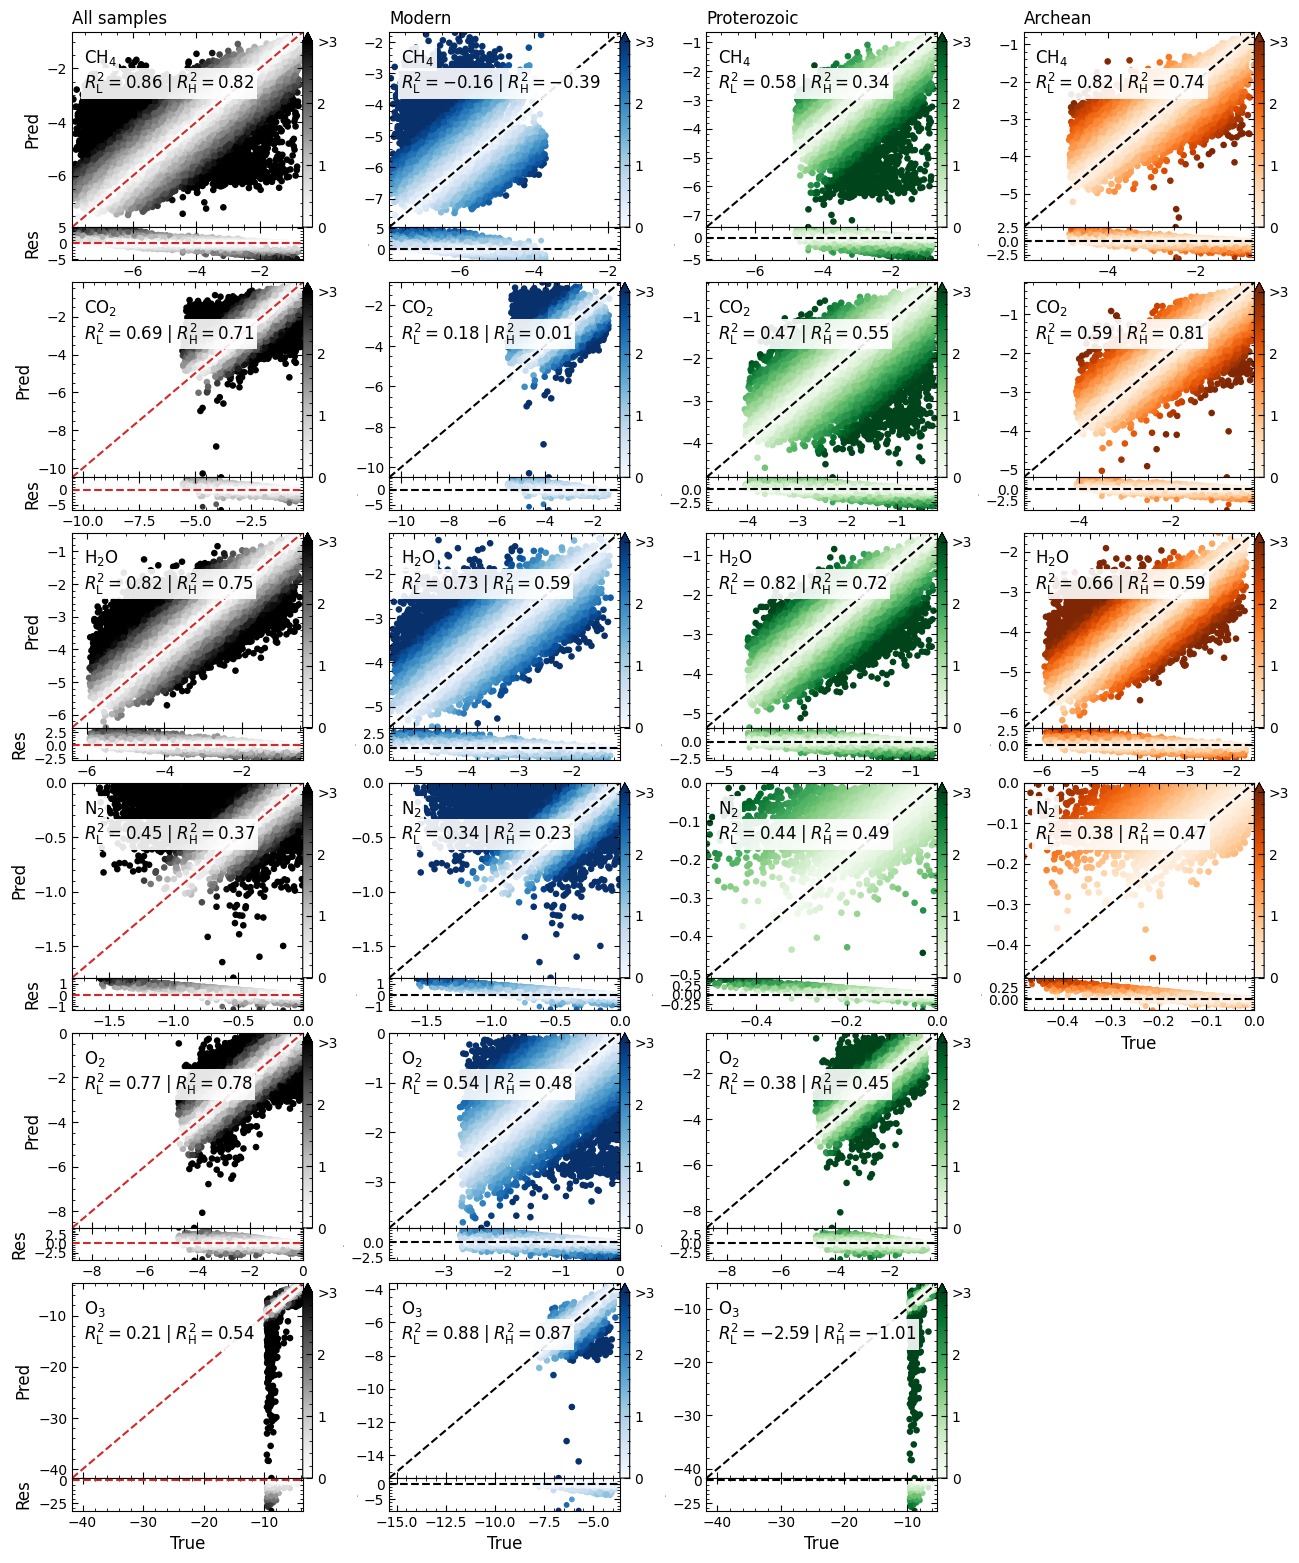

In [32]:
_needed_cols = ['earth_type']
abund_feats  = ['CH4', 'CO2', 'H2O', 'N2', 'O2', 'O3']

for ft in abund_feats:
    _needed_cols.extend([f'true_{ft}_log', f'pred_{ft}_log', f'sigma_{ft}_log'])

results_df_HABEX['earth_type'] = results_df_HABEX['earth_type'].astype(str)

subsets = {
    "All samples": results_df_HABEX,
    "Modern": results_df_HABEX[results_df_HABEX.earth_type.str.lower() == 'modern'],
    "Proterozoic": results_df_HABEX[results_df_HABEX.earth_type.str.lower() == 'proterozoic'],
    "Archean": results_df_HABEX[results_df_HABEX.earth_type.str.lower() == 'archean'],
}

col_labels = list(subsets.keys())

archean_exclude = {'O2', 'O3'}

n_rows_feat = len(abund_feats)
fig_height_per_feat = 3.2
fig_width_per_col   = 4.0

fig = plt.figure(figsize=(fig_width_per_col*4, fig_height_per_feat*n_rows_feat))

outer_gs = gridspec.GridSpec(
    nrows=n_rows_feat, ncols=4, figure=fig,
    wspace=0.1, hspace=0.1, height_ratios=[1]*n_rows_feat, width_ratios=[1]*4
)

cmaps = ['Grays', 'Blues', 'Greens', 'Oranges']
last_col = len(col_labels) - 1
last_row = n_rows_feat - 1

for i_feat, feat in enumerate(abund_feats):
    for j_col, col_name in enumerate(col_labels):
        r2_L_val = r2_LU.get((col_name, feat), np.nan)
        r2_H_val = r2_HB.get((col_name, feat), np.nan)

        #if col_name == "Archean":
        #    [f for f in abund_feats[i_feat+1:] if f not in archean_exclude]
        if col_name == "Archean" and feat in archean_exclude:
          continue

        df_sub = subsets[col_name]
        data = df_sub[[f'true_{feat}_log',
                       f'pred_{feat}_log',
                       f'sigma_{feat}_log']].dropna()
        if data.empty:
            continue

        inner_gs = gridspec.GridSpecFromSubplotSpec(
            nrows=2, ncols=1, subplot_spec=outer_gs[i_feat, j_col],
            height_ratios=[3,0.5], hspace=0
        )

        ax_main = fig.add_subplot(inner_gs[0])
        x = data[f'true_{feat}_log']
        y = data[f'pred_{feat}_log']
        sigma_abs = data[f'sigma_{feat}_log'].abs()

        cmap = cmaps[j_col]
        norm = Normalize(vmin=0, vmax=3, clip=True)
        sc = ax_main.scatter(x, y, c=sigma_abs, cmap=cmap, s=14, norm=norm, rasterized=True)
        lims = [min(x.min(), y.min()), max(x.max(), y.max())]
        ax_main.plot(lims, lims, ls='--', lw=1.5, color='tab:red' if col_name == "All samples" else 'k')
        ax_main.set_xlim(lims)
        ax_main.set_ylim(lims)

        pretty = {
            'CH4': r'CH$_4$',
            'CO2': r'CO$_2$',
            'H2O': r'H$_2$O',
            'N2' : r'N$_2$',
            'O2' : r'O$_2$',
            'O3' : r'O$_3$',
        }

        ax_main.text(
            0.05, 0.92,
            pretty.get(feat, feat),
            transform=ax_main.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2.0))

        ax_main.text(
            0.05, 0.8,
            rf'$R^2_{{\mathrm{{L}}}}={r2_L_val:.2f}\;|\;R^2_{{\mathrm{{H}}}}={r2_H_val:.2f}$',
            transform=ax_main.transAxes,
            fontsize=12, va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.9, edgecolor="none", pad=2)
        )

        ax_main.tick_params(labelbottom=False)
        ax_main.set_ylabel('Pred' if j_col==0 else '')
        if i_feat == 0:
            ax_main.set_title(col_name, loc="left")

        cbar = fig.colorbar(sc, ax=ax_main, orientation='vertical', fraction=0.2, pad=0, extend='max')
        ticks = [0, 1, 2, 3]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(['0', '1', '2', '>3'])

        ax_res = fig.add_subplot(inner_gs[1], sharex=ax_main)

        pos_main = ax_main.get_position()        # [x0, y0, width, height]
        pos_res  = ax_res.get_position()
        ax_res.set_position([pos_main.x0,        # keep left edge aligned
                            pos_res.y0,         # keep current vertical placement
                            pos_main.width,     # match the (shrunk) width of ax_main
                            pos_res.height])    # keep current height

        res = y - x
        ax_res.scatter(x, res, c=sigma_abs, cmap=cmap, s=10, rasterized=True)

        ax_res.axhline(0, ls='--', lw=1.5, color='tab:red' if col_name == "All samples" else 'k')
        ax_res.set_ylim(res.min(), res.max())
        ax_res.set_xlabel('True')
        ax_res.set_ylabel('Res', fontsize=12 if j_col==0 else 0)

        last_feat_for = {
            "All samples": abund_feats[-1],
            "Modern"     : abund_feats[-1],
            "Proterozoic": abund_feats[-1],
            "Archean"    : [f for f in abund_feats if f not in archean_exclude][-1]
        }

        need_xlabel = (feat == last_feat_for[col_name])
        ax_res.set_xlabel('True' if need_xlabel else '')

fig.savefig("pred_vs_true_chemical.pdf", bbox_inches='tight')
#fig.savefig("pred_vs_true_chemical.svg", format='svg', bbox_inches='tight')
plt.show()

# FIGURE 2

In [18]:
features = ['RADIUS_REL_EARTH', 'GRAVITY', 'TEMP','PRESSURE']

r2_L = {f: r2_score(
            results_df_LUVOIR[f'true_{f}_original'],
            results_df_LUVOIR[f'pred_{f}_original'])
        for f in features}

r2_H = {f: r2_score(
            results_df_HABEX[f'true_{f}_original'],
            results_df_HABEX[f'pred_{f}_original'])
        for f in features}

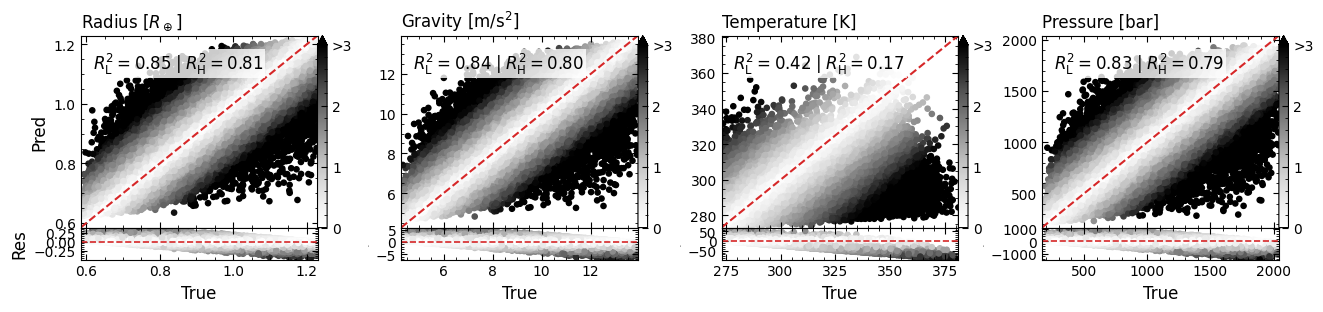

In [35]:
pretty_labels = {
    'RADIUS_REL_EARTH': r'Radius [$R_\oplus$]',
    'GRAVITY': r'Gravity [m/s$^2$]',
    'TEMP': r'Temperature [K]',
    'PRESSURE': r'Pressure [bar]',
}

n_feat = len(features)
n_cols = 4
n_rows = 2
fig_width_per_col = 4.0
fig_height_per_row = 3.2

fig = plt.figure(figsize=(fig_width_per_col * n_cols, fig_height_per_row * n_rows))
outer_gs = gridspec.GridSpec(
    nrows=n_rows, ncols=n_cols, figure=fig,
    wspace=0.15, hspace=0.2
)

for idx, feat in enumerate(features):
    row = idx // n_cols
    col = idx % n_cols

    true_col = f'true_{feat}_original'
    pred_col = f'pred_{feat}_original'

    x = results_df_HABEX[true_col]
    y = results_df_HABEX[pred_col]
    sigma_abs = results_df_HABEX[f'sigma_{feat}_original'].abs()

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        nrows=2, ncols=1, subplot_spec=outer_gs[row, col],
        height_ratios=[3, 0.5], hspace=0
    )

    ax_main = fig.add_subplot(inner_gs[0])
    norm = Normalize(vmin=0, vmax=3, clip=True)
    ticks = [0, 1, 2, 3]
    sc = ax_main.scatter(x, y, c=sigma_abs, norm=norm, cmap='Grays', s=14, rasterized=True)

    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax_main.plot(lims, lims, ls='--', lw=1.5, color='tab:red')
    ax_main.set_xlim(lims)
    ax_main.set_ylim(lims)

    ax_main.set_ylabel('Pred' if col==0 else '')
    ax_main.tick_params(labelbottom=False)

    ax_main.set_title(pretty_labels.get(feat, feat), loc="left")

    ax_main.text(
        0.05, 0.92,
        rf'$R^2_{{\mathrm{{L}}}}={r2_L[feat]:.2f}\;|\;R^2_{{\mathrm{{H}}}}={r2_H[feat]:.2f}$',
        transform=ax_main.transAxes,
        fontsize=12, va='top', ha='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1.5)
    )

    cbar = fig.colorbar(sc, ax=ax_main, orientation='vertical', pad=0, extend='max')
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(['0', '1', '2', '>3'])

    # --- RESIDUALS ---
    ax_res = fig.add_subplot(inner_gs[1], sharex=ax_main)

    pos_main = ax_main.get_position()        # [x0, y0, width, height]
    pos_res  = ax_res.get_position()
    ax_res.set_position([pos_main.x0,        # keep left edge aligned
                        pos_res.y0,         # keep current vertical placement
                        pos_main.width,     # match the (shrunk) width of ax_main
                        pos_res.height])    # keep current height

    residuals = y - x
    ax_res.scatter(x, residuals, c=sigma_abs, cmap='Grays', s=14, rasterized=True)
    ax_res.axhline(0, ls='--', lw=1.2, color='tab:red')
    ax_res.set_ylim(residuals.min(), residuals.max())
    ax_res.set_xlabel('True')
    ax_res.set_ylabel('Res', fontsize=12 if col==0 else 0)

fig.savefig("pred_vs_true_planetary_params.pdf", bbox_inches='tight')
plt.show()